# Bayesian Regression in Pyro: GDP and Terrain Ruggedness

1. [Introduction](#1.-Introduction)
2. [Dataset](#2.-Dataset)
3. [Bayesian Linear Regression](#3.-Bayesian-Linear-Regression)
    1. [Model](#3.1.-Model)
    2. [SVI with an AutoDiagonalNormal Guide](3.2.-SVI-with-AutoDiagonalNormal-Guide)
    3. [Exact Inference Using Hamiltonian Monte Carlo](#3.3-Exact-Inference-using-Hamiltonian-Monte-Carlo)
    4. [Comparing Posterior Distributions](#3.4-Comparing-Posterior-Distributions)
    4. [Better Posterior Approximation Using AutoMultivariateNormal Guide](#3.5-Better-Posterior-Approximation-Using-AutoMultivariateNormal-Guide)
4. [Model Predictions](#4.-Model-Predictions)
    1. [Log GDP Prediction for Africa and Non Africa](#4.1-Log-GDP-prediction-for-Africa-and-Non-Africa)
    2. [Regression Coefficient for Terrain Ruggedness](#4.2.-Regression-Coefficient-for-Terrain-Ruggedness)

### 1. Introduction

The following simple bayesian regression example is adapted from \[1\]. We will use the dataset from \[2\], replicate the authors' central point in the paper (see below), and use this to motivate different ways of doing bayesian regression in Pyro - i.e. faster and scalable approximate inference via Variational Inference, or exact (though slower) inference via Hamiltonian Monte Carlo.

*Abstract - Ruggedness: The blessing of bad geography in Africa*


> We show that geography, through its impact on history, can have important effects on current economic development. The analysis focuses on the historic interaction between ruggedness and Africa's slave trades. Although rugged terrain hinders trade and most productive activities, negatively affecting income globally, within Africa rugged terrain afforded protection to those being raided during the slave trades. Since the slave trades retarded subsequent economic development, within Africa ruggedness has also had a historic indirect positive effect on income. Studying all countries worldwide, we estimate the differential effect of ruggedness on income for Africa. We show that the differential effect of ruggedness is statistically significant and economically meaningful, it is found in Africa only, it cannot be explained by other factors like Africa's unique geographic environment, and it is fully accounted for by the history of the slave trades.


  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012

In [96]:
from __future__ import absolute_import, division, print_function

import argparse
from functools import partial
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [97]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"

### 2. Dataset 

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[2\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the dataset and plot this relationship.

We will be using only three columns from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
We will also take the logarithm for the response variable, GDP. This is a common practice as the relationship of wealth to its causal factors is often exponential due to the *rich get richer phenomenon*.

In [98]:
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [99]:
rugged_data.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

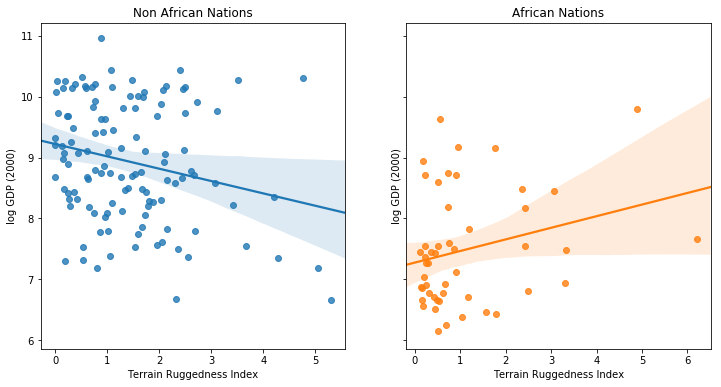

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = rugged_data[rugged_data["cont_africa"] == 1]
non_african_nations = rugged_data[rugged_data["cont_africa"] == 0]
sns.regplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.regplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

As can be seen from the figure above, for most nations ruggedness corresponds to lower GDP per capita. This can be attributed to multiple reasons, transporation and hence trade difficulties being the chief one. We also observe a reversal in this relationship for African nations - i.e. higher terrain ruggedness generally corresponds to higher GDP per capita. The authors posit that more rugged terrains were an important factor in protecting nations from slave traders historically, which tended to have positive effects on income later.

### 3. Bayesian Linear Regression

Let us try to use bayesian linear regression to see if we can capture and quantify this relationship. We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index.

### 3.1. Model

The model below specifies the generative process. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept. Note that simple linear regression cannot account for a reversal in the relationship between one of the predictors and the response. There is an interaction between `is_cont_africa` and `rugged`, and the simplest way to incorporate this interaction effect in the model is through a linear interaction term `is_cont_africa x rugged`. The regression coefficient for this is given by `bAR`. 

Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data, and a noninformative prior on `sigma`.

In [101]:
def model(is_cont_africa, ruggedness):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        mu = pyro.sample("mu", dist.Delta(mean))
        pyro.sample("obs", dist.Normal(mu, sigma))

In [102]:
# We would like to sample "mu" after running our 
# inference routines. 
blocked_model = poutine.block(model, hide=["mu"])

In [103]:
def conditioned_model(log_gdp, *args, **kwargs):
    return poutine.condition(blocked_model, data={"obs": log_gdp})(*args, **kwargs)

In [104]:
# Utility functions

def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites).get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

### 3.2. SVI with AutoDiagonalNormal Guide

To fit our bayesian linear regression model, we will use Variational Inference with an automatically constructed guide that samples the latent variables from a gaussian distribution with a diagonal covariance matrix.

In [105]:
guide = AutoDiagonalNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 711.0378744602203
Elbo loss: 562.2051140069962
Elbo loss: 540.5025813579559
Elbo loss: 556.1372275948524
Elbo loss: 431.0891190767288
Elbo loss: 475.5846165418625
Elbo loss: 420.4479727745056
Elbo loss: 348.26895439624786
Elbo loss: 263.1031770706177
Elbo loss: 251.32574927806854
Elbo loss: 250.42726653814316
Elbo loss: 252.04949194192886
Elbo loss: 253.44519740343094
Elbo loss: 253.12009328603745
Elbo loss: 252.11544144153595
Elbo loss: 252.48652184009552
Elbo loss: 252.8092356324196
Elbo loss: 256.06440514326096
Elbo loss: 252.3032926917076
Elbo loss: 254.63079851865768


In [106]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

Let us observe the posterior distribution over the different latent variables in the model.

In [107]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std        5%       25%       50%      75%       95%
0  9.17655  0.075848  9.048189  9.127528  9.176575  9.22428  9.307671 

Site: bA
       mean       std        5%       25%      50%       75%      95%
0 -1.858027  0.142452 -2.101235 -1.957869 -1.85501 -1.760963 -1.61832 

Site: bR
       mean       std        5%       25%       50%       75%      95%
0 -0.171139  0.040524 -0.236366 -0.198515 -0.172364 -0.143669 -0.10209 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.365132  0.077681  0.239206  0.310348  0.365644  0.420096  0.488811 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.928539  0.053597  0.844445  0.891435  0.927459  0.961546  1.016167 



### 3.3 Exact Inference using Hamiltonian Monte Carlo

In contrast to using Variational Inference which gives us an approximate posterior over our latent variables, we can also do exact inference using MCMC. The algorithm that we will be using is called the No-U Turn Sampler (NUTS), which provides an efficient and automated way of running Hamiltonian Monte Carlo.

In [108]:
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) \
    .run(log_gdp, is_cont_africa, ruggedness)

INFO 	 Starting MCMC using kernel - NUTS ...
INFO 	 Iteration: 60 [WARMUP]
INFO 	 Step size: 0.047448 	 Acceptance rate: 0.900000
INFO 	 Iteration: 120 [WARMUP]
INFO 	 Step size: 0.026504 	 Acceptance rate: 0.916667
INFO 	 Iteration: 180 [WARMUP]
INFO 	 Step size: 0.048566 	 Acceptance rate: 0.922222
INFO 	 Iteration: 240 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.937500
INFO 	 Iteration: 300 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.946667
INFO 	 Iteration: 360 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.952778
INFO 	 Iteration: 420 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.959524
INFO 	 Iteration: 480 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.962500
INFO 	 Iteration: 540 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.964815
INFO 	 Iteration: 600 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.968333
INFO 	 Iteration: 660 [SAMPLE]
INFO 	 Step size: 0.040820 	 Acceptance rate: 0.968182
INFO 	 Ite

In [109]:
for site, values in summary(hmc_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%      75%       95%
0  9.180432  0.132965  8.969815  9.089544  9.18383  9.26496  9.392599 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.845503  0.216206 -2.212787 -1.989948 -1.846219 -1.692509 -1.505288 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.180907  0.073212 -0.303719 -0.229934 -0.181421 -0.130844 -0.059207 

Site: bAR
      mean       std        5%       25%       50%       75%       95%
0  0.35053  0.126546  0.139363  0.265373  0.350971  0.430429  0.552002 

Site: sigma
       mean       std       5%       25%       50%       75%       95%
0  0.952274  0.051746  0.86994  0.918309  0.949878  0.984835  1.042242 



### 3.4 Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from Variational Inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from Variational Inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents.

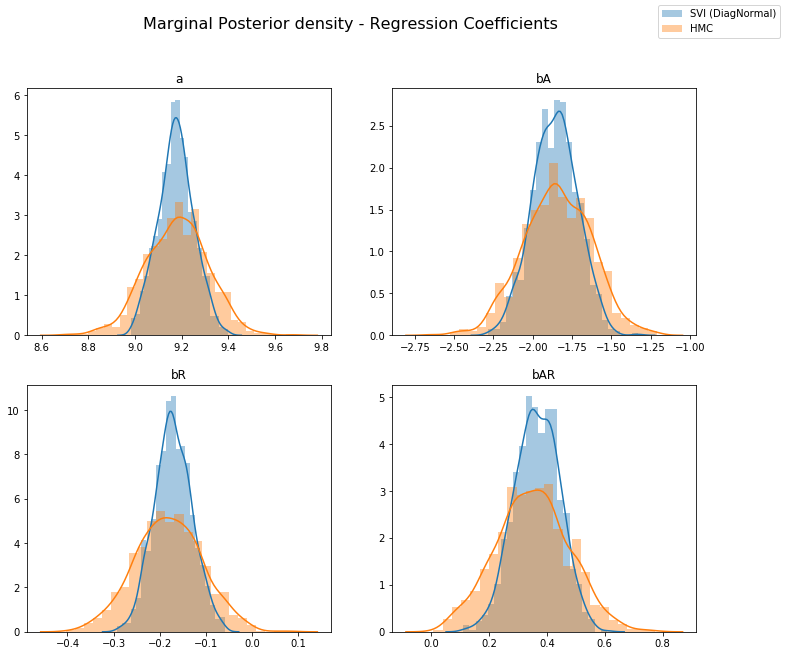

In [110]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         .get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites).get_samples_and_weights()[0].numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

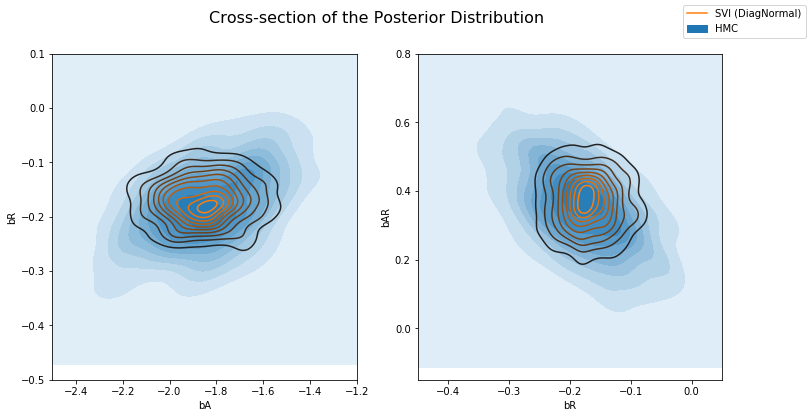

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### 3.5 Better Posterior Approximation Using AutoMultivariateNormal Guide

As comparison to the previously obtained results from AutoDiagonalNormal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution. We can see that the resulting posterior distribution is very close to the true posterior.

In [112]:
guide = AutoMultivariateNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 1648.4510706663132
Elbo loss: 625.1504362821579
Elbo loss: 533.7504343986511
Elbo loss: 531.9391865134239
Elbo loss: 552.7667526006699
Elbo loss: 491.89299005270004
Elbo loss: 528.1743412017822
Elbo loss: 514.81562769413
Elbo loss: 376.52491730451584
Elbo loss: 320.072822868824
Elbo loss: 282.32349091768265
Elbo loss: 257.7351184487343
Elbo loss: 253.2874356508255
Elbo loss: 271.1556897163391
Elbo loss: 250.83103346824646
Elbo loss: 253.19994449615479
Elbo loss: 254.32788515090942
Elbo loss: 250.958340883255
Elbo loss: 252.27314865589142
Elbo loss: 251.96602195501328


In [113]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

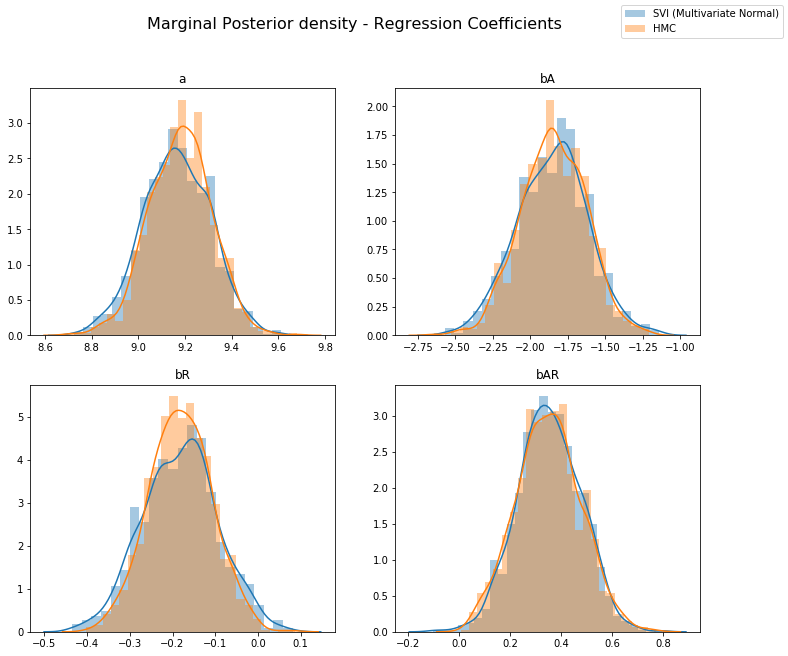

In [114]:
svi_mvn_empirical = EmpiricalMarginal(svi_mvn_posterior, sites=sites).get_samples_and_weights()[0] \
                    .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_mvn_empirical[:, i], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

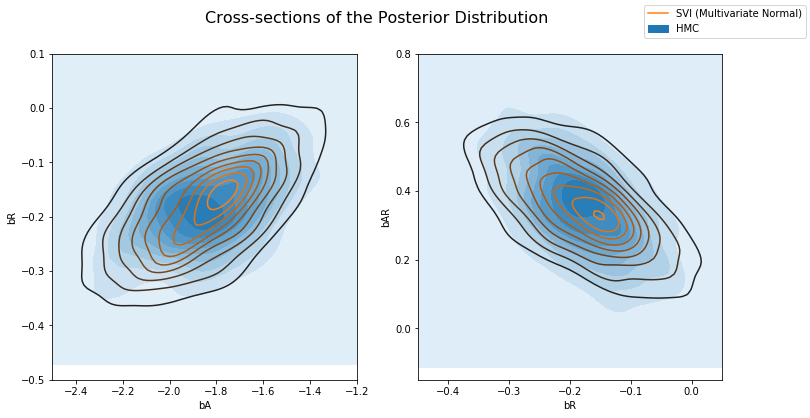

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### 4. Model Predictions

Let us plot the predictions from HMC (results are similar for SVI with AutoMultiariatNormal guide). 

In [120]:
trace_pred = TracePredictive(model,
                             hmc_posterior,
                             num_samples=1000)
post_pred = trace_pred.run(is_cont_africa, ruggedness)
post_summary = summary(post_pred, sites=["mu", "obs"])
mu = post_summary["mu"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": train[:, 0],
    "rugged": train[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": train[:, 2]
})

### 4.1 Log GDP prediction for Africa and Non Africa

Let us plot the distribution of the regression line (`"mu"` in the model), for African and non-African nations separately. 

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

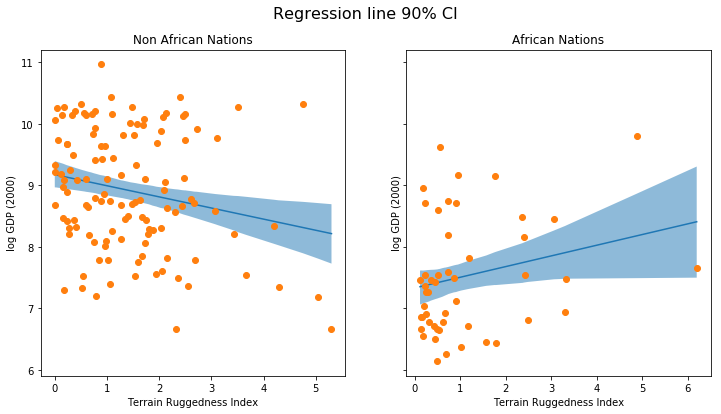

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

The above figure shows the uncertainty in our estimte of the regression line. Note that for lower values of ruggedness there are many more data points, and as such, lesser wiggle room for the line of best fit. This is reflected in the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by `sigma`! Let us do so next.

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

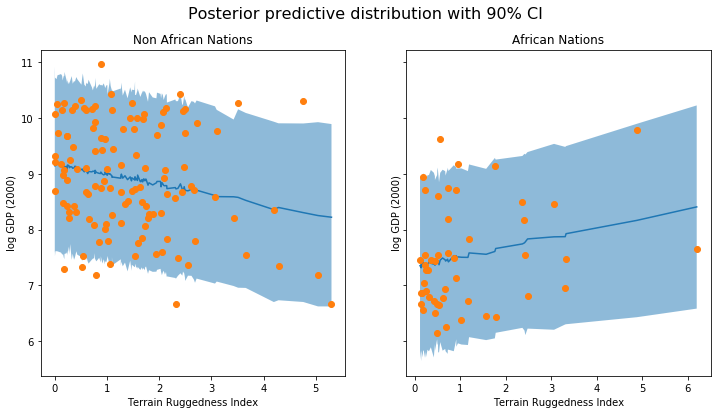

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is a good idea to do such posterior predictive checks to see if our model gives valid predictions.

### 4.2. Regression Coefficient for Terrain Ruggedness 

Let us plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa. As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations.

Text(0.5,0.98,'Density of Slope : log(GDP) vs. Terrain Ruggedness')

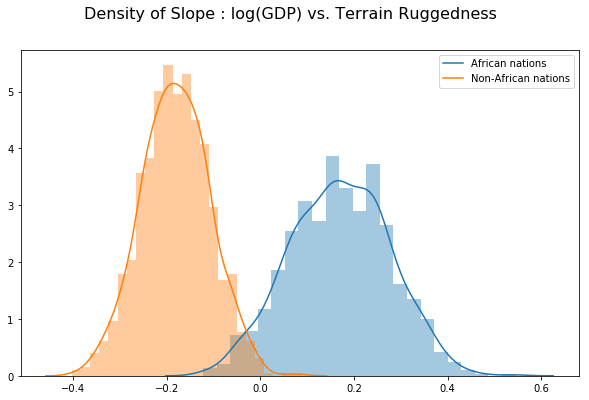

In [125]:
gamma_within_africa = hmc_empirical[:, 2] + hmc_empirical[:, 3]
gamma_outside_africa = hmc_empirical[:, 2]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)